# Depth Image (Lecture 10)

# 第一部分：三维深度信息的获取与处理

## 深度图定义

通常，物体的远近会通过像素的亮度来表示。一种常见的约定是：**离相机越近的物体，像素越亮（白色）；离相机越远的物体，像素越暗（黑色）。**

#### `z depth` vs. `ray depth` 的区别

**A. `z depth` (平面深度)**

- **定义**：`z depth` 测量的是场景中的一个点，沿着**平行于相机光轴 (z轴) 的方向**，到相机成像平面（或相机中心所在平面）的垂直距离。
- 在计算机视觉中，我们使用的标准透视投影模型 `x' = f * (X/Z)` 和 `y' = f * (Y/Z)` 里的那个 **Z**，**就是 `z depth`**。使用 `z depth` 可以让3D点到2D像素的坐标转换变得非常简洁。几乎所有的消费级深度相机（如Kinect, RealSense）输出的都是 `z depth`。

**B. `ray depth` (射线深度 / 欧几里得距离)**

- **定义**：`ray depth` 测量的是从**相机光心（可以想象成针孔模型的那个小孔）到场景中那个点**的**直线距离**。

#### 为什么是2.5D

1. **缺少内参矩阵K**

从深度图的 (u, v, d) 得到三维坐标的 (X, Y, Z) ，这个过程我们称为反投影（Unprojection）。

反投影的公式是：

- Z = d
- X = (u - cx) / fx * Z
- Y = (v - cy) / fy * Z

要完成这个转换，必须知道相机的**焦距 (fx, fy)** 和**主点 (cx, cy)**。也就是**内参矩阵K。**

1. **不能计算两个点之间的距离**

这是最核心的一点。假设在深度图上取了两个像素点：

- 点 A: 位于像素 (u1, v1)，深度为 d1。
- 点 B: 位于像素 (u2, v2)，深度为 d2。

想计算A和B在真实三维空间中的距离。这个距离应该是 sqrt( (X1-X2)² + (Y1-Y2)² + (Z1-Z2)² )。

- Z1=d1, Z2=d2，已知
- 但是 因为我们**缺少内参K**，无法将 (u1, v1) 和 (u2, v2) 转换成物理坐标。

错误地计算：sqrt( (u1-u2)² + (v1-v2)² + (d1-d2)² )。在数学上是荒谬的，因为把**像素**和**米**这两种完全不同的单位进行了加减运算，没有意义。

## 深度传感器 (Depth Sensors)

获取深度图像主要依赖于深度传感器

### 立体视觉传感器 (Stereo Sensors)
*   **原理**：模拟人眼，使用两个或多个相机从不同位置拍摄同一场景。通过寻找左右图像中的同名点（像素），计算它们在水平方向上的像素差，这个差值被称为 **视差（Disparity）**。
*   **视差与深度的关系**：视差与物体的深度成 **反比**。物体越近，视差越大；物体越远，视差越小。
    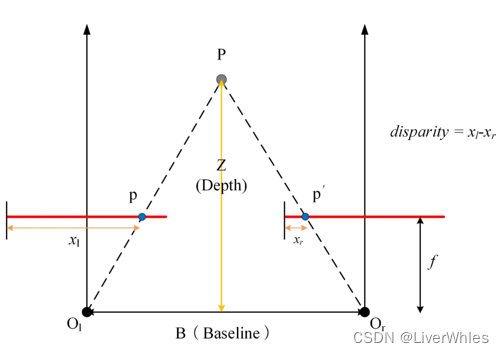
    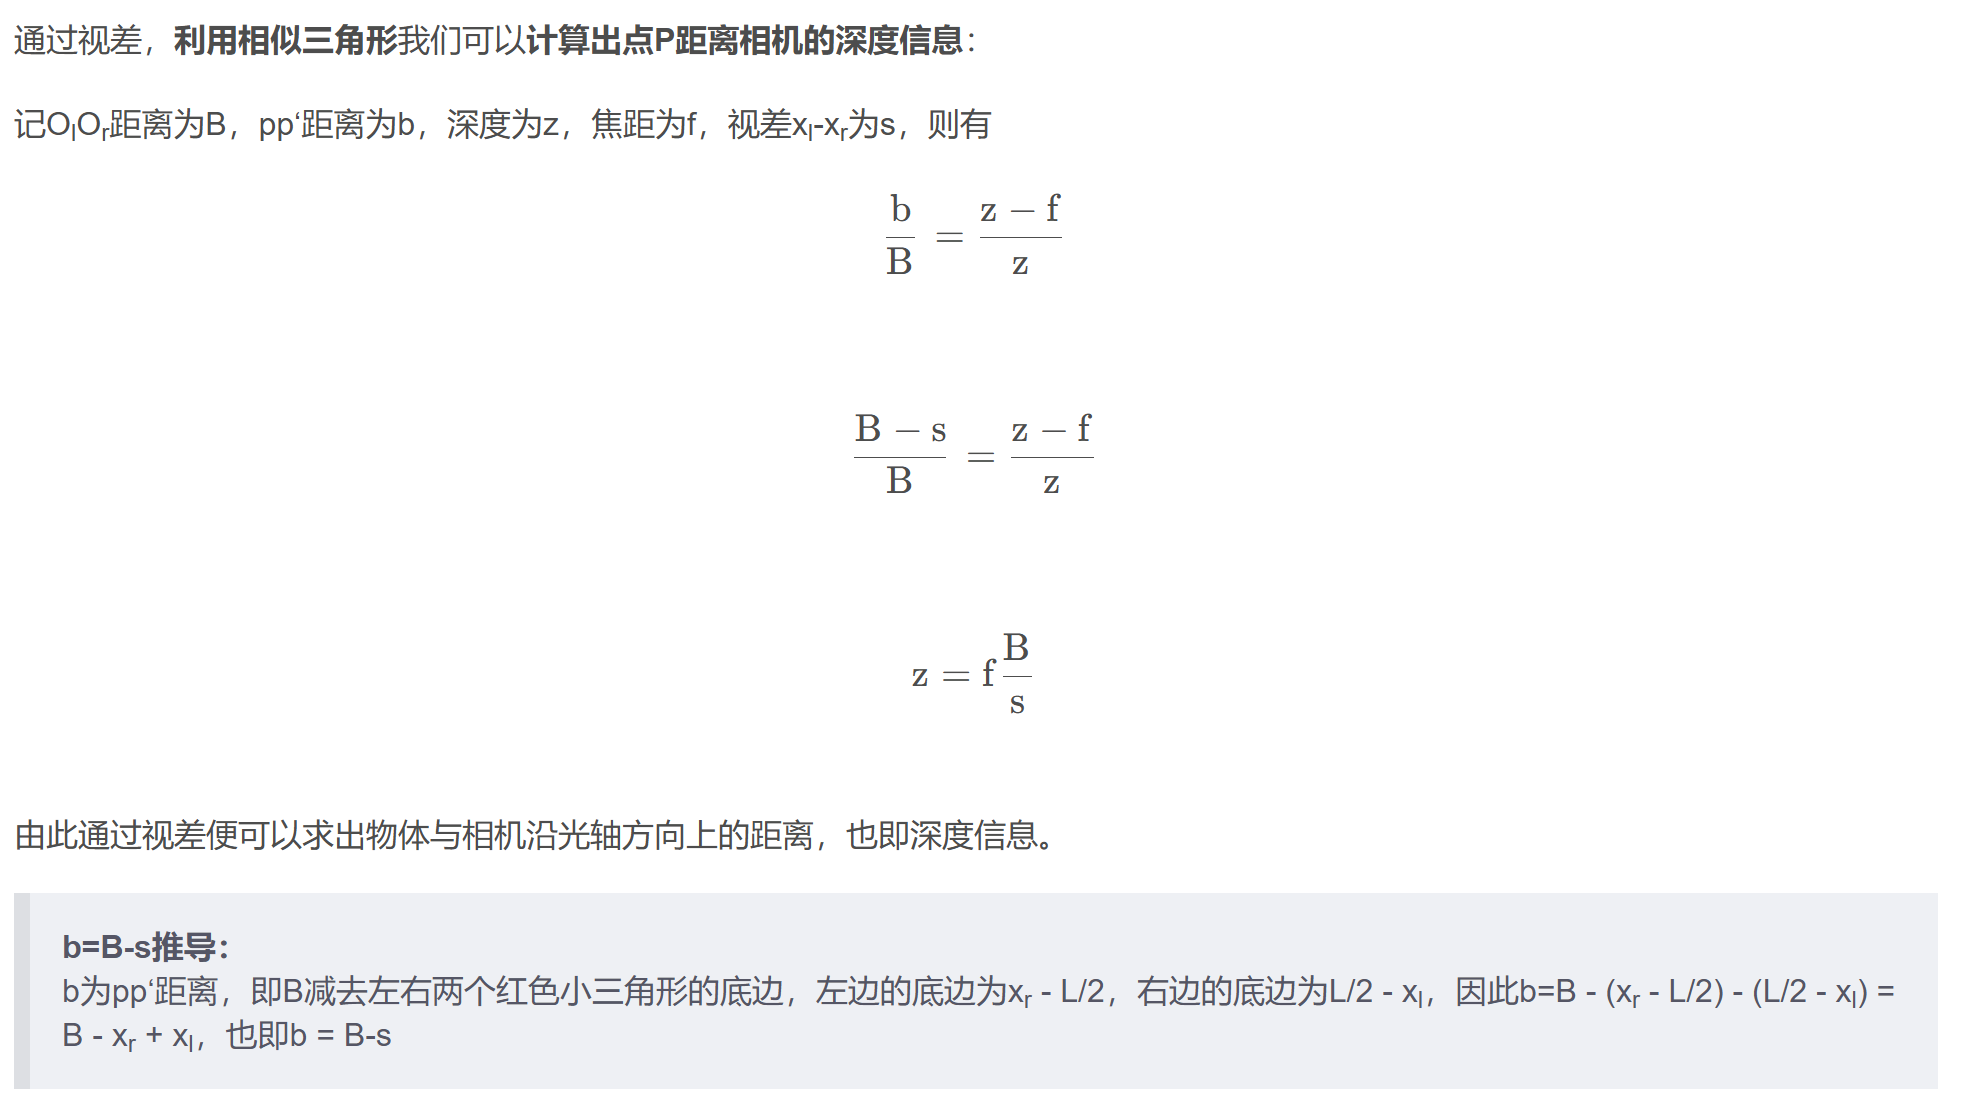
    $$
    \text{disparity} = u - u' = \frac{B \cdot f}{z}
    $$
    其中 `B` 是两相机基线距离，`f` 是焦距，`z` 是深度。
*   **优缺点**：
    *   优点：适用于difuuse surface(漫反射平面)且有unique texture的。
    *   缺点：依赖于特征匹配，在 **无纹理区域**、**重复纹理区域**、**遮挡** 和 **反光/透明表面**（镜子上同一个点，由于镜面反射左右眼看到的实际上是不同的东西） 处容易匹配失败，导致深度计算错误。
*   **几个术语**

| 术语 | 中文释义 | 核心概念 | 典型示例 |
| :--- | :--- | :--- | :--- |
| **Lambertian Surface**（朗伯表面） | 朗伯表面 | 这是一种**理想的漫反射表面**。它完全无光泽，能将入射光均匀地反射到所有方向，且表观亮度与观察角度无关，是理想的“漫反射表面”。 | 在计算机图形学中，常将不光滑的哑光材质（如matte paint）近似为朗伯表面。 |
| **Diffuse Surface**（漫反射表面） | 漫射面、漫反射面 | 光线照射到粗糙表面时，被**均匀地散射到各个方向**。因此，从任何视角看，表面的亮度都基本相同，无光泽感。 | 一张白纸、粉刷的墙面、 dusty chalkboard（ dusty 黑板） |
| **Specular**（镜面反射） | 镜面的、高光的 | 光线在光滑表面发生**镜面般的反射**，反射角等于入射角。由此产生的高光亮点**强烈依赖于观察角度**。 | 镜子、平静的水面、抛光金属 |
| **Transparent**（透明） | 透明的 | 光线可以**穿透**物质，使得背后的物体清晰可见。与物体表面如何反射光（漫反射/镜面反射）是不同的概念。 | 玻璃窗、纯净水、透明塑料 |

### 结构光/主动立体视觉 (Structured Light / Active Stereo)
*   **原理**：它通过一个 **投影仪** 主动向场景中投射具有特定图案（如红外散斑）的光，再由一个或多个相机进行拍摄。因为投射的图案是已知的，这极大地简化了特征匹配的难度，即使在无纹理的表面上也能形成有效特征点。
*   **优缺点**：
    *   优点：能够在各种光照条件下，甚至黑暗中，生成稠密的3D数据。
    *   缺点：投射的光可能会被其他红外光源（如强光）干扰，且在透明或高反光物体上表现不佳（光会被穿透或反射掉）。

# 第二部分：三维数据的表示方法

*   **规则表示 (Regular Form)**：如深度图、体素（Voxel），数据结构规整，类似图像栅格，易于用标准CNN处理，但通常计算和存储开销大。
*   **不规则表示 (Irregular Form)**：如 **网格 (Mesh)** 和 **点云 (Point Cloud)**，它们更灵活、更高效地表示物体表面，是当前研究的重点。

## 1. 网格 (Mesh)

*   **定义**：由一系列 **顶点 (Vertices)**、**边 (Edges)** 和 **面 (Faces)** 构成的集合，用于近似表示三维物体的表面。
*   **数据结构**：
    *   **STL格式**：简单地存储每个三角面的三个顶点坐标，但没有共享顶点信息，存储冗余且无连接性。
    *   **索引面集 (Indexed Face Set)**：如OBJ格式，是更高效的方式。它维护一个顶点列表和一个面列表。面列表不直接存储坐标，而是存储构成该面的顶点的 **索引**，顺序符合右手法则。这种方式大大减少了存储量，并保留了拓扑结构。
*   **测地距离 (Geodesic Distance)**：网格的一个重要性质是可以在其表面上计算距离，即“贴着表面走”的最短路径，这与空间中的直线距离（欧氏距离）不同。

## 2. 点云 (Point Cloud)

*   **定义**：一个仅由三维空间中点的集合 `N×3` 构成的简单数据结构。每个点只包含 `(x, y, z)` 坐标，有时也会有颜色、法向量等额外属性。
*   **核心特性**：
    1.  **无序性 (Orderless)**：点云中点的顺序可以任意打乱，但其所代表的形状不变。
    2.  **不规则性 (Irregular)**：点在空间中分布不均。
    3.  **轻量级**：表示方式简单，存储开销小。
*   **从网格采样点云**：点云可以通过从网格表面采样得到。
    *   **均匀采样 (Uniform Sampling)**：根据每个三角面片的面积大小作为权重，随机抽取面片，再在被抽中的面片内均匀采样点。优点是简单，缺点是采样出的点分布可能不均匀。
    *   **最远点采样 (Farthest Point Sampling, FPS)**：一种保证采样点在空间上尽可能均匀分布的贪心算法。其过程是：先随机选一个点，然后迭代地选择离已有采样点集最远的点加入集合。
        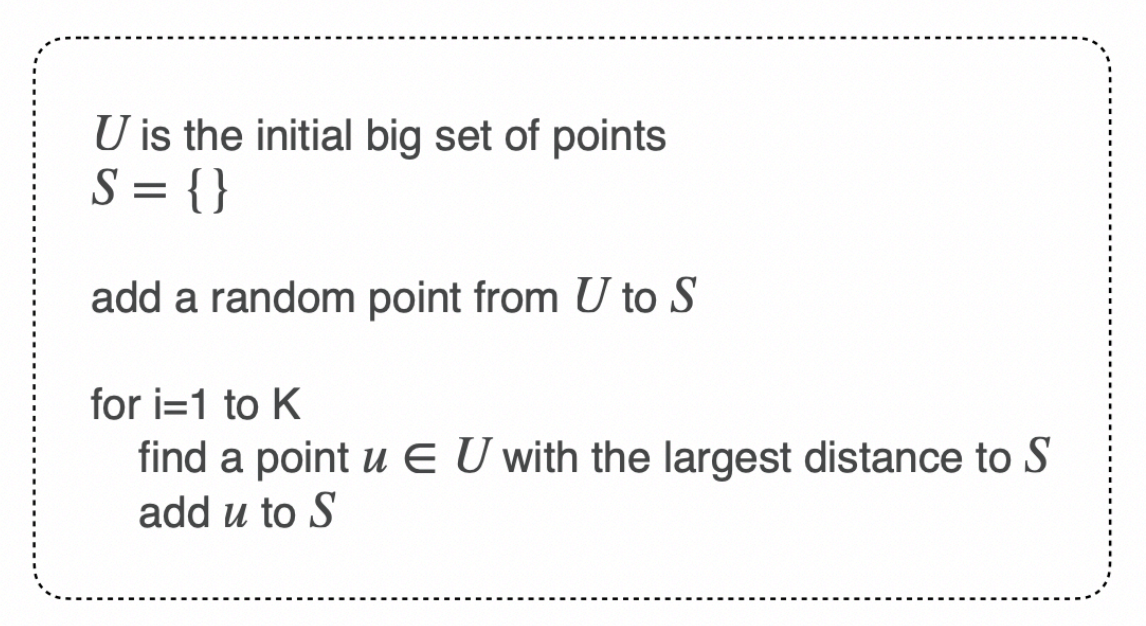

*   **点云间的距离度量**：如何衡量两个点云的相似度？
    *   **倒角距离 (Chamfer Distance, CD)**：
        $$
        d_{CD}(S_1, S_2) = \sum_{x \in S_1} \min_{y \in S_2} ||x-y||_2 + \sum_{y \in S_2} \min_{x \in S_1} ||x-y||_2
        $$
        它计算的是：对于 $S_1$ 中的每个点，找到 $S_2$ 中最近的点的距离，然后求和；反之亦然，再将两项相加。它衡量的是两个点云集合之间的平均最近距离，对点的数量不敏感，但对离群点敏感。

    *   **推土机距离 (Earth Mover's Distance, EMD)**：
        $$
        d_{EMD}(S_1, S_2) = \min_{\phi: S_1 \to S_2} \sum_{x \in S_1} ||x - \phi(x)||_2
        $$
        它要求两个点云大小相等，并寻找一个最优的一一对应关系（双射 $\phi$），使得所有对应点对之间的总距离最小。EMD能更好地捕捉形状的整体结构，但计算复杂度远高于CD。
### 为什么二者对于取样的敏感性不同（CD不敏感，EMD敏感）

*   CD允许“多对一”的潜在匹配。一个好的点可以服务于多个邻近点，从而掩盖了另一个点云在局部区域的采样缺失。它衡量的是两个点云在多大程度上互相靠近，而不是它们的分布有多相似。

*   EMD强制执行“一对一”的全局匹配。它惩罚的不仅仅是距离，更是分布上的不一致。如果一个点云在某个区域有聚集，而另一个在相同区域有空洞，EMD会通过强制远距离匹配来严厉地惩罚这种不匹配。


# 第三部分：针对点云的深度学习

传统的CNN依赖于规则的像素网格结构，而点云的 **无序性** 和 **不规则性** 使其无法直接应用。如果强行将点云输入一个标准的神经网络，仅仅改变输入点的顺序就会导致完全不同的输出，这不符合点云的本质。

## PointNet：

*   **核心思想**：利用 **对称函数 (Symmetric Function)** 来实现对输入点顺序的 **排列不变性 (Permutation Invariance)**。
    *   对称函数无论其输入变量如何排序，输出结果都保持不变。例如 `sum()` 和 `max()`。
    *   PointNet 的设计哲学是：`f(h(x_1), h(x_2), ..., h(x_n))`，如果 `f` 是一个对称函数（如 `max_pooling`），那么整个网络就对 `x_1` 到 `x_n` 的顺序不敏感了。

*   **网络架构**：
    1.  **逐点特征提取**：使用共享的多层感知机（MLP）独立地对每个输入点进行处理，将其从3维坐标提升到高维特征空间（例如1024维）。
    2.  **对称操作（聚合）**：对所有点的高维特征，在特征维度上进行 **最大池化 (Max Pooling)** 操作。这一步将所有点的信息聚合成一个单一的 **全局特征向量**。这是实现排列不变性的关键。
    3.  **输出**：将这个全局特征向量输入到另一个MLP中，进行分类或其它任务。
    4.  **分割任务的扩展**：对于分割任务，需要为每个点预测一个标签。PointNet的做法是将全局特征向量与每个点的局部特征（在Max Pooling之前的特征）拼接起来，再通过MLP为每个点输出预测结果。

*   **优点**：轻量、快速，且对点的缺失和扰动非常鲁棒。因为Max Pooling操作只关心特征的最大值，丢失一些非关键点对全局特征影响不大。

*   **缺点**：
    1.  **缺乏局部信息**：PointNet对每个点独立处理，然后直接聚合为全局特征，完全忽略了点与点之间的局部几何结构（如一个点的邻域长什么样）。
    2.  **对坐标敏感**：全局特征依赖于绝对坐标，泛化能力有限。
    
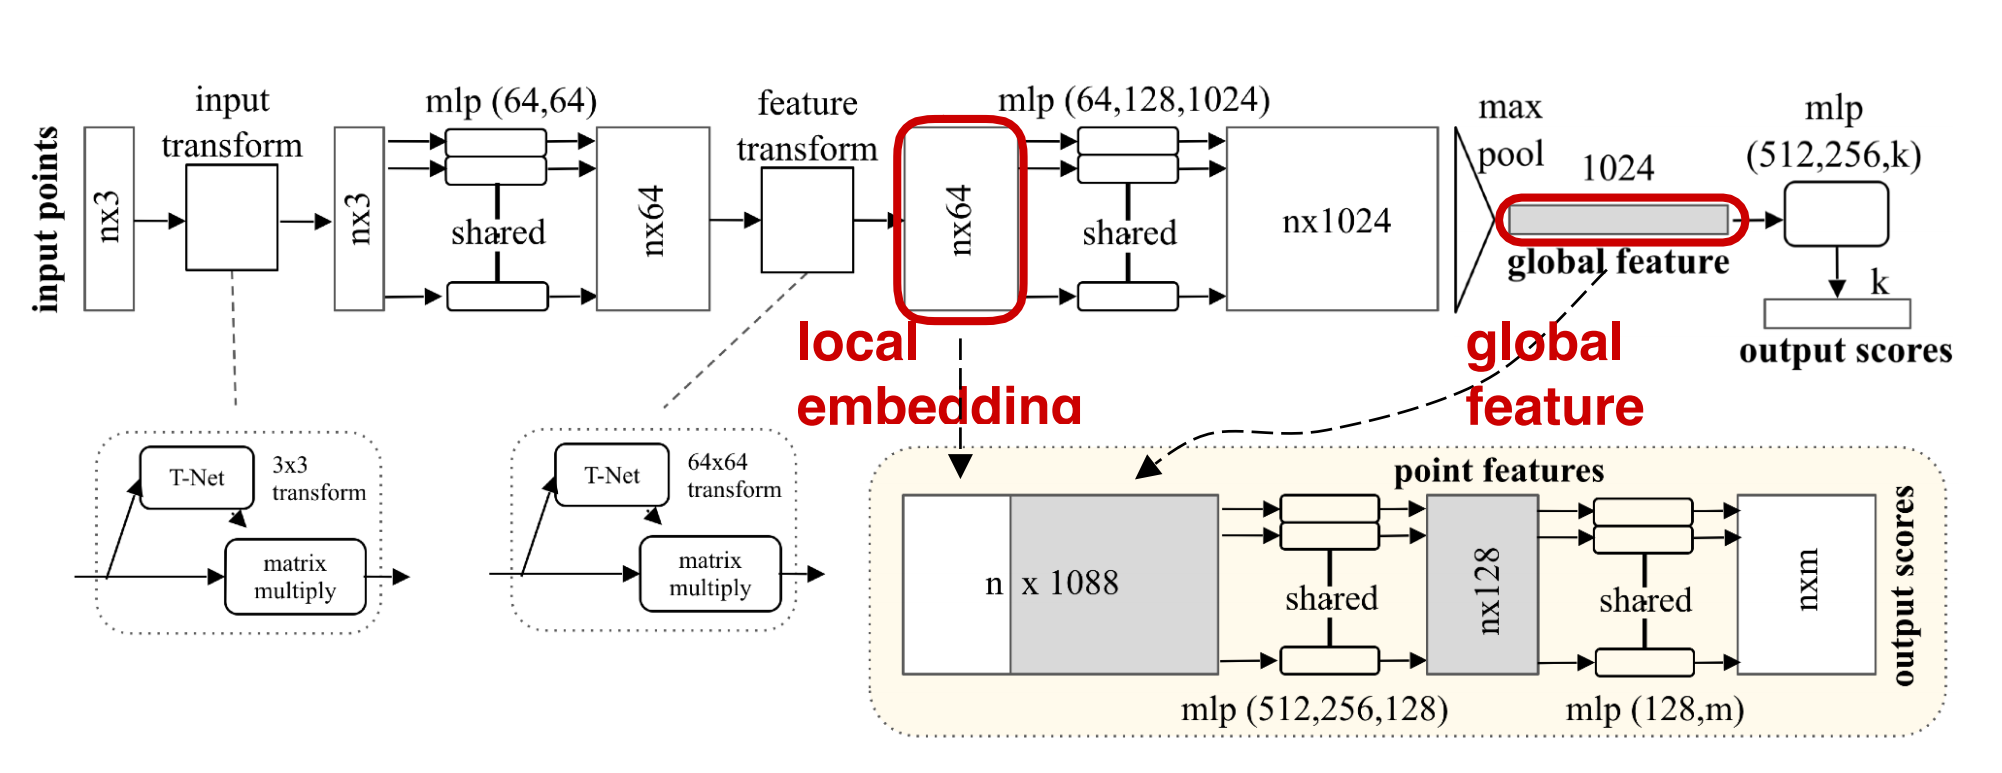

## PointNet++：引入层级结构

*   **核心思想**：借鉴CNN中感受野逐层增大的思想，在PointNet的基础上引入 **层级特征学习** 机制，从而捕捉不同尺度的局部信息。

*   **关键模块：Set Abstraction Layer**
    这是一个重复使用的核心模块，每层都包含三个步骤：
    1.  **采样 (Sampling)**：使用 **最远点采样 (FPS)** 从输入点云中选择一部分点作为局部区域的中心点。
    2.  **分组 (Grouping)**：对于每个中心点，通过 **球查询 (Ball Query)** 找到其邻域内的所有点，形成一个局部点集。
    3.  **局部特征提取 (PointNet)**：将每个局部点集送入一个迷你的PointNet网络中进行处理，提取出该局部区域的特征向量。

*   **网络架构**：
    *   通过堆叠多个Set Abstraction Layer，PointNet++能够逐层提取特征。第一层学习小范围的几何细节，后续层在更大范围上对这些细节进行组合，从而学习到更抽象的特征。
    *   **分割任务**：对于分割，PointNet++采用类似U-Net的编码器-解码器结构。通过 **上采样和特征传播** 将高层级的抽象特征逐步插值回原始点云，并结合来自编码器阶段的低层级特征，实现精细的逐点预测。

